In [14]:
import numpy as np
import pandas as pd
import torch
import h5py
import matplotlib.pyplot as plt

In [2]:
from transformers import AutoformerConfig, AutoformerModel

In [3]:
PATH_TO_RAW_DATA = "/Volumes/fsmresfiles/Basic_Sciences/Phys/Lerner_Lab_tnl2633/Gaby/MetaData_ForMike/organized_data/all_photometry_data"
path_to_signal_recording = "/Volumes/fsmresfiles/Basic_Sciences/Phys/Lerner_Lab_tnl2633/Gaby/Data Analysis /ActiveAvoidance/ShuttleBox_Cohort3/D1-Cre_Cohort3/ActiveAvoidanceShuttleBox-220810/152-070_071-220810-140331/152-070_071-220810-140331_output_1/z_score_DA.hdf5"

In [40]:
# read h5 file
with h5py.File(path_to_signal_recording, "r") as f:
    print(f.keys())
    data = f["data"]
    data = np.array(data)
    

<KeysViewHDF5 ['data']>


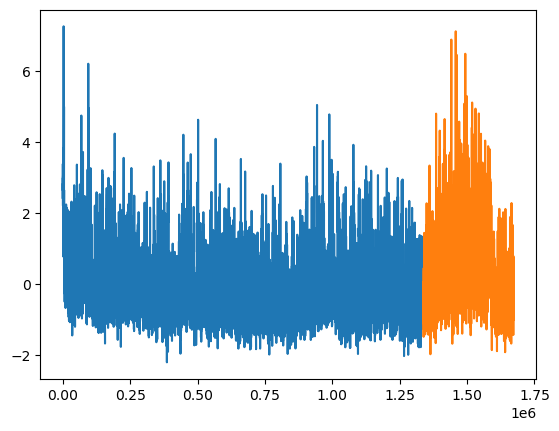

In [41]:
time = range(0, len(data), 1)
train_time = time[0:int(0.8*len(time))]
test_time = time[int(0.8*len(time)):]

train_x = data[0:int(0.8*len(data))]
test_x = data[int(0.8*len(data)):]

plt.plot(train_time, train_x)
plt.plot(test_time, test_x)


In [42]:
configuration = AutoformerConfig(prediction_length=90)
model = AutoformerModel(configuration)

mask = torch.BoolTensor([False] * len(train_x))
train_time = torch.Tensor(train_time)



In [52]:
model.forward(past_values=train_x, past_observed_mask=mask)

TypeError: AutoformerModel.forward() missing 1 required positional argument: 'past_time_features'